In [1]:
!pip install biopython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 29.6 MB/s eta 0:00:00


Prueba con secuencias de ADN:
Matriz de distancias:
[[0.         0.12025699 0.82395922 0.67345619 0.44084   ]
 [0.12025699 0.         0.82395922 0.67345619 0.67345619]
 [0.82395922 0.82395922 0.         0.38311922 0.82395922]
 [0.67345619 0.67345619 0.38311922 0.         1.3438196 ]
 [0.44084    0.67345619 0.82395922 1.3438196  0.        ]]

Resultado UPGMA:


<ipython-input-3-761d953e7e85>:34: RuntimeWarning: invalid value encountered in multiply
  i, j = np.unravel_index(np.argmin(distance_matrix + np.eye(len(distance_matrix)) * np.inf), distance_matrix.shape)


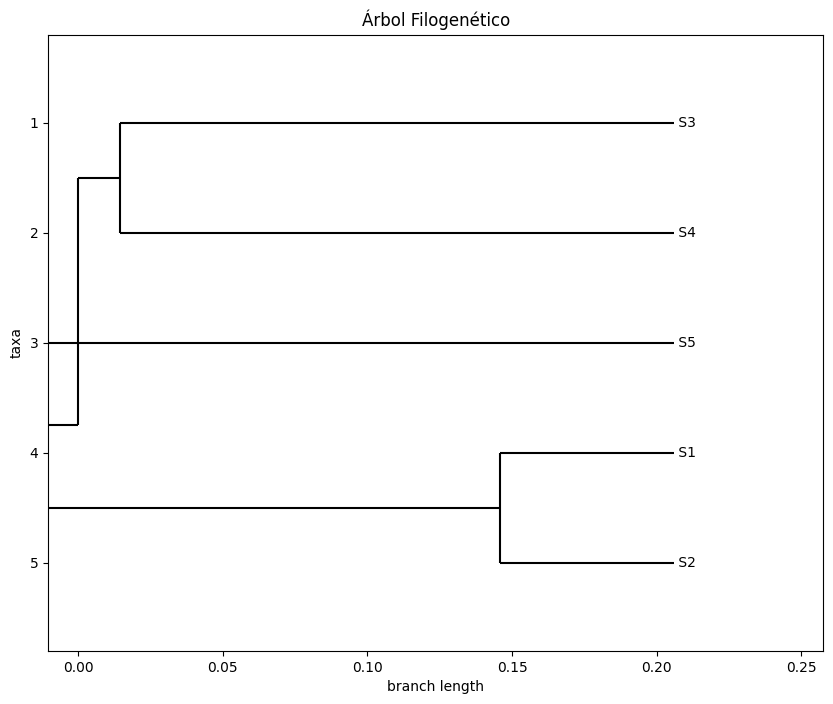


Resultado Neighbor Joining:


<ipython-input-3-761d953e7e85>:65: RuntimeWarning: invalid value encountered in multiply
  i, j = np.unravel_index(np.argmin(q_matrix + np.eye(n) * np.inf), q_matrix.shape)


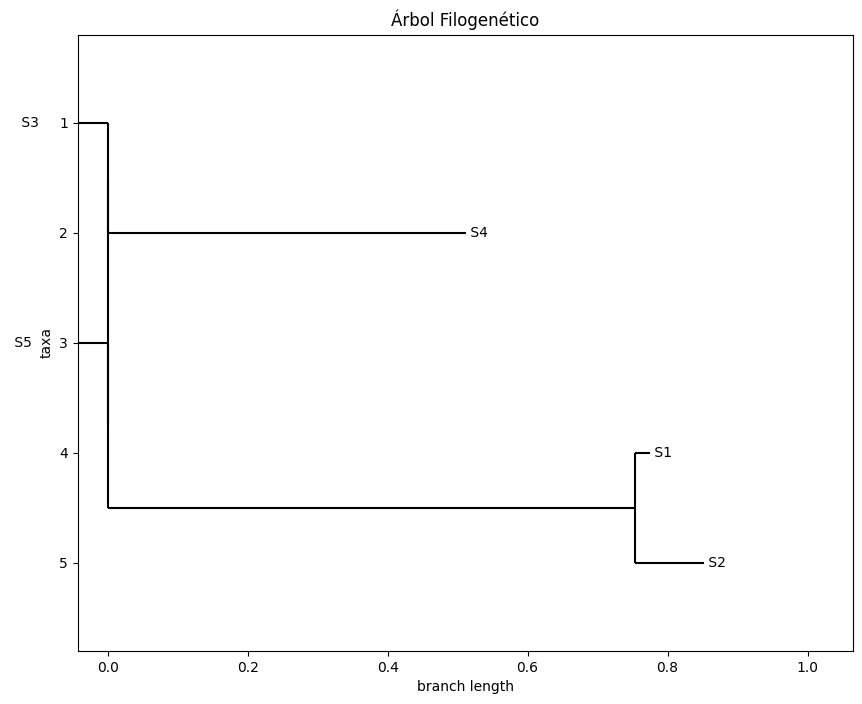


Prueba con apellidos:
Matriz de distancias de apellidos:
[[ 0 15 17 13 12 15]
 [15  0 14 18 15 16]
 [17 14  0 18 16 15]
 [13 18 18  0 14 16]
 [12 15 16 14  0 15]
 [15 16 15 16 15  0]]

Resultado UPGMA para apellidos:


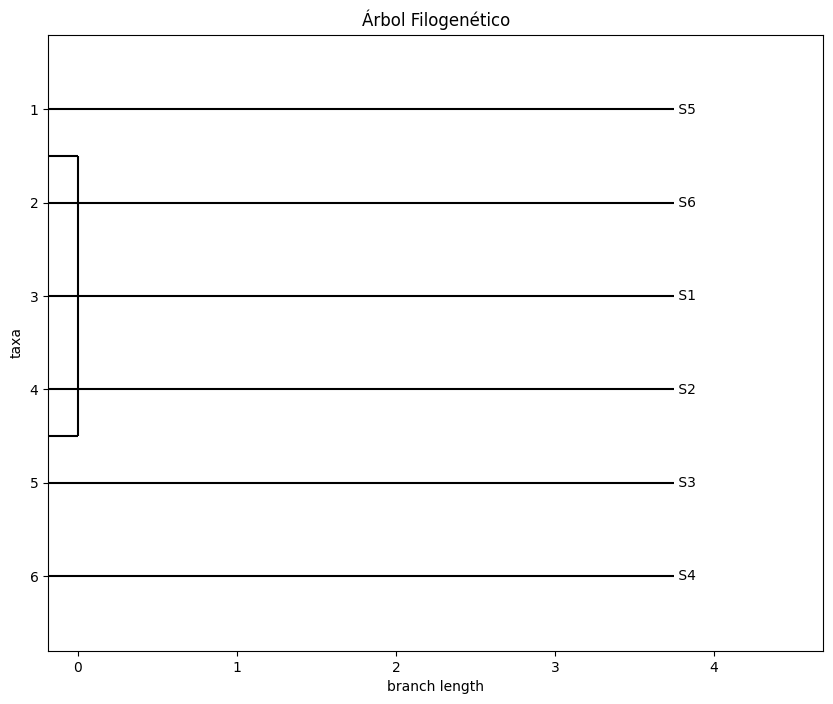


Resultado Neighbor Joining para apellidos:


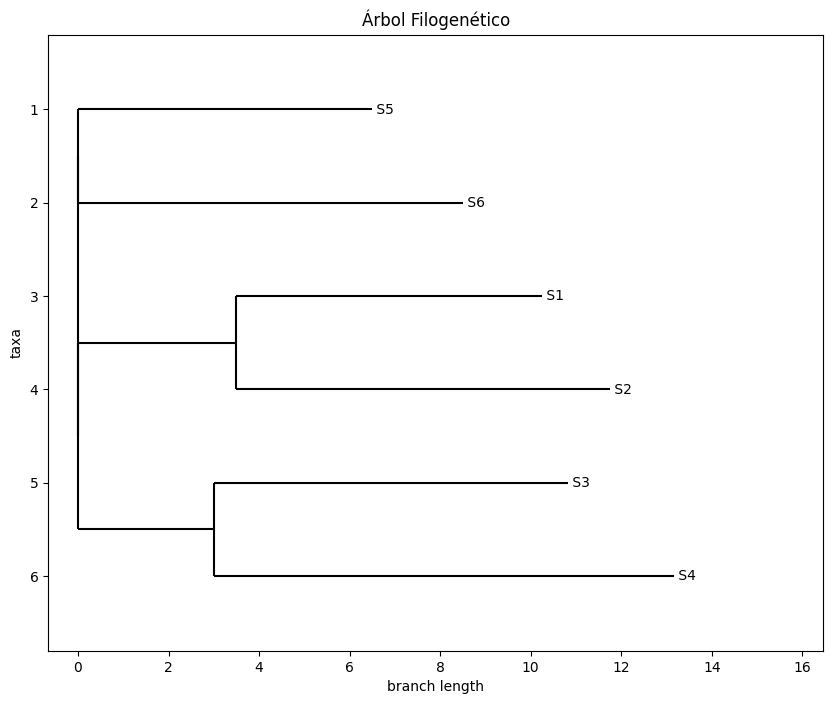

In [3]:
# Importar bibliotecas necesarias
import numpy as np
import matplotlib.pyplot as plt
from Bio import Phylo
from io import StringIO
import itertools

# Función para calcular la distancia entre dos secuencias
def calculate_distance(seq1, seq2):
    differences = sum(c1 != c2 for c1, c2 in zip(seq1, seq2))
    total_length = max(len(seq1), len(seq2))
    p = differences / total_length
    distance = -0.75 * np.log(1 - (4/3) * p)
    return distance

# Función para calcular la matriz de distancias
def distance_matrix(sequences):
    n = len(sequences)
    matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(i+1, n):
            dist = calculate_distance(sequences[i], sequences[j])
            matrix[i][j] = matrix[j][i] = dist
    return matrix

# Implementación del algoritmo UPGMA
def upgma(distance_matrix):
    n = len(distance_matrix)
    nodes = [f'S{i+1}' for i in range(n)]
    tree = {node: [] for node in nodes}
    heights = {node: 0 for node in nodes}

    while len(nodes) > 1:
        i, j = np.unravel_index(np.argmin(distance_matrix + np.eye(len(distance_matrix)) * np.inf), distance_matrix.shape)
        height = distance_matrix[i][j] / 2
        new_node = f'({nodes[i]}:{height-heights[nodes[i]]},{nodes[j]}:{height-heights[nodes[j]]})'
        tree[new_node] = [nodes[i], nodes[j]]
        heights[new_node] = height

        new_distances = (distance_matrix[i] + distance_matrix[j]) / 2
        distance_matrix = np.delete(np.delete(distance_matrix, [i, j], 0), [i, j], 1)
        distance_matrix = np.vstack([distance_matrix, new_distances[:-2]])
        distance_matrix = np.hstack([distance_matrix, np.append(new_distances[:-2], 0).reshape(-1, 1)])

        nodes = [node for k, node in enumerate(nodes) if k not in [i, j]] + [new_node]

    return tree, nodes[0]

# Implementación del algoritmo Neighbor Joining
def neighbor_joining(distance_matrix):
    n = len(distance_matrix)
    nodes = [f'S{i+1}' for i in range(n)]
    tree = {node: [] for node in nodes}

    while len(nodes) > 2:
        n = len(distance_matrix)
        total_distances = np.sum(distance_matrix, axis=0)
        q_matrix = np.zeros((n, n))

        for i in range(n):
            for j in range(n):
                if i != j:
                    q_matrix[i][j] = (n - 2) * distance_matrix[i][j] - total_distances[i] - total_distances[j]

        i, j = np.unravel_index(np.argmin(q_matrix + np.eye(n) * np.inf), q_matrix.shape)

        delta = (total_distances[i] - total_distances[j]) / (n - 2)
        li = (distance_matrix[i][j] + delta) / 2
        lj = (distance_matrix[i][j] - delta) / 2

        new_node = f'({nodes[i]}:{li},{nodes[j]}:{lj})'
        tree[new_node] = [nodes[i], nodes[j]]

        new_distances = np.zeros(n-1)
        for k in range(n):
            if k not in [i, j]:
                new_distances[k if k < min(i, j) else k-1] = (distance_matrix[i][k] + distance_matrix[j][k] - distance_matrix[i][j]) / 2

        distance_matrix = np.delete(np.delete(distance_matrix, [i, j], 0), [i, j], 1)
        distance_matrix = np.vstack([distance_matrix, new_distances[:-1]])
        distance_matrix = np.hstack([distance_matrix, np.append(new_distances[:-1], 0).reshape(-1, 1)])

        nodes = [node for k, node in enumerate(nodes) if k not in [i, j]] + [new_node]

    final_node = f'({nodes[0]}:{distance_matrix[0][1]/2},{nodes[1]}:{distance_matrix[0][1]/2})'
    tree[final_node] = nodes
    return tree, final_node

# Función para visualizar el árbol
def visualize_tree(newick_tree):
    tree = Phylo.read(StringIO(newick_tree), "newick")
    fig, ax = plt.subplots(figsize=(10, 8))
    Phylo.draw(tree, axes=ax, do_show=False)
    plt.title("Árbol Filogenético")
    plt.show()

# Función para calcular la distancia entre apellidos
def surname_distance(surname1, surname2):
    return sum(c1 != c2 for c1, c2 in itertools.zip_longest(surname1.lower(), surname2.lower(), fillvalue=''))

# Función principal para ejecutar pruebas
def run_tests():
    # Prueba con secuencias de ADN
    sequences = [
        "ATTGCCATT",
        "ATGGCCATT",
        "ATCCAATTTT",
        "ATCTTCTT",
        "ACTGACC"
    ]

    print("Prueba con secuencias de ADN:")
    dist_matrix = distance_matrix(sequences)
    print("Matriz de distancias:")
    print(dist_matrix)

    print("\nResultado UPGMA:")
    upgma_tree, upgma_root = upgma(dist_matrix)
    visualize_tree(upgma_root)

    print("\nResultado Neighbor Joining:")
    nj_tree, nj_root = neighbor_joining(dist_matrix)
    visualize_tree(nj_root)

    # Prueba con apellidos
    surnames = [
        "García López",
        "Martínez Rodríguez",
        "Fernández González",
        "López Sánchez",
        "González Pérez",
        "Rodríguez Martín"
    ]

    print("\nPrueba con apellidos:")
    surname_matrix = np.array([[surname_distance(s1, s2) for s2 in surnames] for s1 in surnames])
    print("Matriz de distancias de apellidos:")
    print(surname_matrix)

    print("\nResultado UPGMA para apellidos:")
    upgma_tree_surnames, upgma_root_surnames = upgma(surname_matrix)
    visualize_tree(upgma_root_surnames)

    print("\nResultado Neighbor Joining para apellidos:")
    nj_tree_surnames, nj_root_surnames = neighbor_joining(surname_matrix)
    visualize_tree(nj_root_surnames)

# Ejecutar las pruebas
if __name__ == "__main__":
    run_tests()